#  Clustering Safety Observations based on Root Causes

## Clustering Safety Observations using Natural Language Learning Process to identify root causes.

In [1]:
# importing necessary modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
%matplotlib inline

## 1. Importing Data

The data which I am using here is a dump from the Safety Observation System of a Major Company. The each row of data consists of the observation description along with pre-selected category and root cause (Classes). These labelings have been done manually. Thus, we aleady have labels in our dataset.

The objective of this program would be to develop a Machine Learning Model which would be able to cluster the EHS Observations based on the historical data and return the optimal numbers of clusters which we will use to guide or further correct our manual labeling process.

By implication this exercise is an Natural Language Processing Exercise, as we will be extracting features from text (Observation Description) and using those for training our clustering model.

The overall plan includes

1. Cleaning the data by removing stops and performing EDA.
2. Feature extraction to arrive on most important features.
3. Feature selection and dimension reduction using Non-Negative Matrix Factorization.
3. Training our different models and measure the performance using pre-identified class labels
4. Evaluation of Models and selection of best model.
5. Summary and Future action.

In [2]:
# let us import the data
df_obs = pd.read_csv('ehs_obs_data.csv')
df_obs.head()

c:\users\aa-minhaj\sklearn-venv\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (0,1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,UA/UC,Observation,Sub-Category
0,Electrically Unsafe (Safety Hazard),worker used drilling machine without green tag.,NaN
1,Electrically Unsafe (Safety Hazard),Worker used a plug top for multiple electrica...,No Plug top
2,Electrically Unsafe (Safety Hazard),worker use drilling machine at site without gr...,NaN
3,Electrically Unsafe (Safety Hazard),Site supervisor is not available at site whi...,NaN
4,Electrically Unsafe (Safety Hazard),worker use electric grinder without green tag.,No Inspection Done


In [3]:
#Let us check the no of columns and rows

print(f'The number of columns in the dataset is {df_obs.shape[1]} and the no of rows is {df_obs.shape[0]}')

The number of columns in the dataset is 3 and the no of rows is 1028493


The target variable here will be 'Sub-Category' and the input variable will be 'Observation'

## 2. Data Cleaning and Wrangling

In this step we will try to 

1. Bring all words on same case (lower case).
2. Detect the missing values and treat them accordingly.
3. Drop various Stop words which don't add any information to the model.

In [4]:
#Let us first bring in all the required modules

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

In [5]:
#lets first drop the 'UA/UC' Column which is not required for this exercise.

df_obs.drop('UA/UC', axis = 1, inplace = True)

In [6]:
df_obs.head()

,Observation,Sub-Category
0,worker used drilling machine without green tag.,NaN
1,Worker used a plug top for multiple electrica...,No Plug top
2,worker use drilling machine at site without gr...,NaN
3,Site supervisor is not available at site whi...,NaN
4,worker use electric grinder without green tag.,No Inspection Done


In [7]:
# Lets check the missing values

df_obs.isnull().sum()

Observation     961881
Sub-Category    996100
dtype: int64

Looks like we have lots of blank rows. However, this may be due to faulty data extraction process and we can easily drop these without losing any meaningful information.

In [8]:
# dropping values
df_obs.dropna(subset = ['Observation'], axis = 0, inplace = True)

In [9]:
# Lets check how many values are missing in target variable after dropping missing feature rows
df_obs.shape[0], df_obs.isnull().sum()

(66612,
 Observation         0
 Sub-Category    34219
 dtype: int64)

We can see that we missing lables for almost half of the data. Now this leaves a lot of room for improvement in data collection and labelling process. Unfortunately, we have to leave out all these rows from our modelling.

In [10]:
#droping values
df_obs.dropna(subset = ['Sub-Category'], axis = 0, inplace = True)
df_obs.shape[0], df_obs.isnull().sum()

(32393,
 Observation     0
 Sub-Category    0
 dtype: int64)

So, in the end we are now left with 32,393 Nos of individual observations

In [11]:
# Lets check for the duplicates in the observation column

df_obs.duplicated(subset = ['Observation'], keep = 'first').sum()

6806

Looks like we have quite a few number of duplicated observation data. It would be better to drop these duplicate columns to avoid any bias in our modelling.

In [12]:
df_obs.drop_duplicates(subset = 'Observation', keep = 'first', ignore_index = True, inplace = True)

In [13]:
# final size of the dataframe
print(f'The number of columns in the dataset is {df_obs.shape[1]} and the no of rows is {df_obs.shape[0]}')

The number of columns in the dataset is 2 and the no of rows is 25587


## Data Cleaning and Wrangling - Summary

* We dropped the null values and duplicated observations to reduce the dimensions of the data
* This also ensures that we avoid assigining higher weightage to certain duplicated observations at the time of feature extraction.
* We also dropped UA/UC columns as we want to explore this dataset purely from NLP perspective.

## 3. Exploratory Data Analysis and Feature Extraction

In this step, we will

1. Remove punctuation marks and anyother extra space.
2. Lemmatize all the words so that different words stemming from same root word are not counted as separate features.
3. Extract features from our observation text using tfidf method.
4. Perform Dimensionality Reduction using NMF

First we will remove the punctuation marks and extra spaces in the string

In [14]:
numbers = map(str, list(range(0, 100)))
for num in numbers:
    df_obs.Observation =  df_obs.Observation.str.replace(num, ' ', regex = False)
special_charecters = ['?', '#', '-', "'", '&', '/', '.', ',', '(', ')', ':',';']
for char in special_charecters:
     df_obs.Observation =  df_obs.Observation.str.replace(char, ' ', regex = False)

In [15]:
df_obs.Observation = df_obs.Observation.apply(lambda x: " ".join(x.split()))
df_obs.Observation = df_obs.Observation.str.strip()

Lets lemmatize our observation text for better results. 

Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. Lemmatization is similar to stemming but it brings context to the words. So it links words with similar meaning to one word.

Text preprocessing includes both Stemming as well as Lemmatization. Many times people find these two terms confusing. Some treat these two as same. Actually, lemmatization is preferred over Stemming because lemmatization does morphological analysis of the words.

We will use WordNetLemmatizer from NTLK library for this purpose

In [16]:
wordlemmatize = WordNetLemmatizer()

In [17]:
def lemmatize_text(word_list):
    lem_word_list = [wordlemmatize.lemmatize(word, pos = 'v') for word in word_list.split()]
    new_lem_word_list = [wordlemmatize.lemmatize(word) for word in lem_word_list]
    return " ".join(new_lem_word_list)

In [18]:
df_obs.Observation = df_obs.Observation.apply(lemmatize_text)

In [19]:
#Lets check our cleaned dataframe

df_obs.sample(10)

,Observation,Sub-Category
14301,At shirur HDPE pipe line observe that unscreen...,Workmen engaged without screening/ Induction
1680,Electrical cable be find lay in work area at site,"Cable issues(Routing, Sub-standard etc)"
18925,Electrical cable have be lay in access egreess...,Cable/Wire run across accessway
18960,approach to sump well be block by reinforcemen...,Unsafe/ Blocked Access & Egress
9360,At bhukanhatti oht observe that the water sump...,Openings not covered/ barricaded
9656,Hard barricade be do from inside of excavation...,No Hard Barricading
9879,Mr umesh workman have not be complete inductio...,Workmen engaged without screening/ Induction
15420,supervisor naresh be find without screen and m...,Workmen engaged without screening/ Induction
12221,Worker do manhole excavation work without use ...,No/ Improper/ Inadequate Shoring
23791,MISSING EDGE PROTEC TION AT SLAB,Hand/Mid rails not provided


If you watch closely lemmatization has taken affect on many words for ex- against index 7778 the word 'been' has been stemmed to 'be', the word 'kept' has been changed back to 'keep' at 7656. In reality, these words would have been extracted as separate features thereby increasing the overall feature dimension

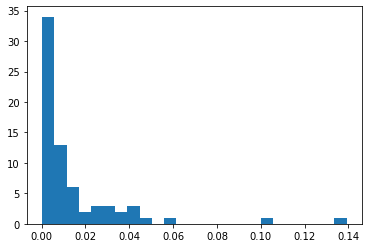

In [20]:
plt.hist(df_obs['Sub-Category'].value_counts(normalize = True), bins = 25,);

This shows that our classes have quite severe imbalance. However, we are not going to use these labels for clustering, but we will use them to validate our results. Also, this gives an idea about what should be No. of Components that we should be targeting during the Non-Negative Matrix Factorization

Next and probably most important step for modelling is to extract features from text data. Now there are many methods to acheive this objective but the most important from all is Term Frequency and Inverse Document Frequnecy Method.

In information retrieval, tf–idf, TF*IDF, or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. tf–idf is one of the most popular term-weighting schemes today.

Another important term that you will come across would be N-grams. In the fields of computational linguistics and probability, an n-gram is a contiguous sequence of n items from a given sample of text or speech. The items can be phonemes, syllables, letters, words or base pairs according to the application. The n-grams typically are collected from a text or speech corpus. When the items are words, n-grams may also be called shingles.

Using Latin numerical prefixes, an n-gram of size 1 is referred to as a "unigram"; size 2 is a "bigram" (or, less commonly, a "digram"); size 3 is a "trigram".

For example a feature - 'Safety' is unigram whereas a feature 'Safety Helmet' would be bigram 

In [21]:
# So lets instantiate our tfidfvectorizer by setting feature output for both unigrams and bigrams and Stop words from English
tfidf = TfidfVectorizer(ngram_range = (1,2),
                        stop_words = 'english',
                        min_df = 10,
                       )

The words which are generally filtered out before processing a natural language are called stop words. These are actually the most common words in any language (like articles, prepositions, pronouns, conjunctions, etc) and does not add much information to the text. Also, I have set min_df = 10, which means words that occurred in too few documents, in this case less than 10, should be filtered out.

I would higly recommend the reader to go through sklearn's working with text data resources. https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

There is no requirement to split our data into training and test sets, as we can validate our results using the pre-defined root causes that we already have in the dataset. So, let's seperate the labels from the text data.

In [22]:
X, y = df_obs.Observation, df_obs['Sub-Category']

In [23]:
features = tfidf.fit_transform(X).toarray()

print(f'The feature matrix contains {features.shape[0]} observations with {features.shape[1]} features')

The feature matrix contains 25587 observations with 3521 features


In [24]:
# Let us create the feature matrix for our future reference

feature_matrix = pd.DataFrame(data = features, columns = tfidf.get_feature_names())
feature_matrix.head()

,aaa,absence,absences,access,access agree,access approach,access area,access arrangement,access available,access block,...,xi,xi im,yadav,yadav engage,yard,yard area,zone,zone area,zone duct,zone site
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


That's a lot of features and it would be tedious and inefficient to fit all these features to the model. So, it would be better at this stage that to select features that are most important and that can acheive maximum gains for our models.

We will do this in two steps,

* by computing chi-squared stats between each non-negative feature and class.
* Non-negative matrix factorization

Chi2 score can be used to select the features with the highest values for the test chi-squared statistic from X, which must contain only non-negative features such as booleans or frequencies (e.g., term counts in document classification), relative to the classes.

In [25]:
from sklearn.feature_selection import chi2

In [26]:
# running chi2 test and storing the chi statistics and p_value

chi2_features, p_value = chi2(feature_matrix, y)

In [27]:
# forming the dataframe with features, chi statistics, and p_value

df_chi2_features = pd.DataFrame(data = [feature_matrix.columns, chi2_features, p_value]).T
df_chi2_features.columns = ['Feature_name', 'Chi value', 'p_value']

We form our hyothesis here with the significance level of alpha = 0.05.

Thus our Null hypothesis is that there is no significance association between the input variable and target variable. While our alternate hypothesis is that there is significance association between the input variable and target variable.

Consequently, we will select only those features which have p_value less that 0.05 (Significance level), so that we can reject our null hypothesis.

In [28]:
df_chi2_features.loc[df_chi2_features['p_value']< 0.05].sort_values(by = 'p_value', ascending = True)

,Feature_name,Chi value,p_value
3,access,3547.160904,0.0
2704,screen,2944.971705,0.0
1603,kv hand,2566.39135,0.0
2117,park,9068.242263,0.0
539,compaction,2182.585633,0.0
...,...,...,...
2595,risk,89.655785,0.048076
1146,form sub,89.604797,0.048441
2075,open road,89.589076,0.048555
2636,room,89.572311,0.048676


Here we can see that we have around 1834 features which are statistically significant thus we can retain them for further modeling. Accordingly, we will drop all other features from our feature matrix.

In [29]:
final_features = df_chi2_features.loc[df_chi2_features['p_value']< 0.05].sort_values(by = 'p_value', ascending = True)
final_feature_columns = list(final_features['Feature_name'])
len(final_feature_columns)

1834

Now, its time to reduce the dimensionality of the feature matrix so that the process of further modelling can be eased and improved

First step of which would be to assign the number of the components that we may want to extract. Best policy in this case could be to use the pre-determined labels in our data which we separated as y variable. Let's check for the number of unique classes in our y variable.

In [30]:
print(f'The number of classes in our label variable is {y.nunique()}')

The number of classes in our label variable is 70


In [31]:
# Let's obtain the final feature matrix after dropping unselected features after chi2 text

final_feature_matrix = feature_matrix[final_feature_columns].copy()
final_feature_matrix.shape

(25587, 1834)

So, lets proceed with 70 components. This being the best option given we know the labels in the original dataset.

In [32]:
# importing NMF library

from sklearn.decomposition import NMF

In [63]:
# Creating the nmf model

# nmf_model = NMF(n_components = y.nunique(), 
#             init = 'random',
#             random_state = 100)

In [34]:
# nmf_features = nmf_model.fit_transform(final_feature_matrix)

In [35]:
## Save the model in pickled form for future reference

def pickle_model(model, filename):
    pkl.dump(model, open(filename, 'wb'))
    
def de_pickle(model):
    return pkl.load(open(model, 'rb'))

In [39]:
#pickle_model(nmf_features, 'nmf_features_pkl.sav')

In [40]:
nmf_features = de_pickle('nmf_features_pkl.sav')

In [41]:
nmf_features.shape

(25587, 70)

In [42]:
print(f'The total no of components produced using this model\
 is {nmf_features.shape[1]} and the actual no of features were {nmf_model.components_.shape[1]}')

The total no of components produced using this model is 70 and the actual no of features were 1834


In [43]:
# Lets check the reconstruction error
nmf_model.reconstruction_err_

112.5161949449341

In [44]:
# Lets visualize them in term of dataframe

nmf_features_components_df = pd.DataFrame(nmf_model.components_, columns = final_feature_columns)
nmf_features_components_df.head()

,access,screen,kv hand,park,compaction,pas,pas issue,joint,scatter,safety shoe,...,legal,rod access,damage cable,person site,line,risk,form sub,open road,room,motor
0,0.003523,0.00000,0.0,0.000000,0.000000,0.024603,0.0,0.071696,0.000000,0.0,...,0.0,0.0,0.007119,0.000921,0.0,0.000000,0.00000,0.0,0.00585,0.0
1,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.00000,0.0
2,0.000000,0.00000,0.0,0.000000,0.006570,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.00000,0.0
3,0.000265,0.00000,0.0,0.000229,0.008007,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.000155,0.002006,0.0,0.000000,0.00000,0.0,0.00000,0.0
4,0.000000,0.24065,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.002376,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.001081,0.00057,0.0,0.00000,0.0


In [45]:
# Lets check for each components identified which is the largest contributing featur

column_1 = pd.Series(nmf_features_components_df.idxmax(axis = 1))
column_2 = pd.Series(nmf_features_components_df.max(axis = 1))

largest_component_nmf = pd.concat([column_1, column_2], axis = 1)
largest_component_nmf.columns = ['Feature Names', 'Values']
largest_component_nmf

,Feature Names,Values
0,cable,0.450917
1,engage site,0.440872
2,soil,0.514036
3,place,0.513937
4,process,0.483933
...,...,...
65,hard,1.412570
66,house,0.935118
67,platform,1.453708
68,protection,0.988933


So the top contributing features to our components look quite rational, indicating that we may proceed ahead with the 70 components.

## Exploratory Data Analysis and Feature Extraction -Summary

* We realised that our data consists of highly imbalanced classes.
* Next step was to prepare the text data for further feature extraction. We applied various transformations such as lemmatization amd acheiving homogenization by converting all words into lower case.
* We dropped the pre-defined labels in the dataset and saved them.
* Next, we used tfidfvectorizer to extract features from our text data. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.
* We perfromed chi2 test to extract the best associated features with p-value less than 0.05.
* Finally we used NMF method to decompose our features into 70 components.

## 4. Model Evaluation and Selection

In this step, we will,

1. Select the best model and subsequently the best values for hyperparameters.
2. Select Best Model by using Silhoutte Score Method.

In [46]:
# let us import all the required models

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

### 4.a. KMeans Clustering

* It is the most commonly used model, which works on the principle of finding clusters with distinct centroids.
* We will use this method with smart initialization of centroids using 'KMeans++' method and setting random state so that we can re-produce the results.
* We will loop the algorigthm over cluster numbers varying from 5 to 70. 
* We will select the best cluster number based on Silhoutte Score. This will be method which will be used for all other algorithms also.

In [47]:
n_clusters = list(range(5,71,5))
sse = []

for cluster in n_clusters:
    km_estimator = Pipeline([('scaler', StandardScaler()),
                             ('kmeans', KMeans(n_clusters = cluster, 
                                               init='k-means++',
                                               random_state = 1000))])
    km_estimator.fit_predict(nmf_features)
    labels = km_estimator.named_steps['kmeans'].labels_
    sse.append(silhouette_score(nmf_features, labels))

Text(0, 0.5, 'Silhouette_score')

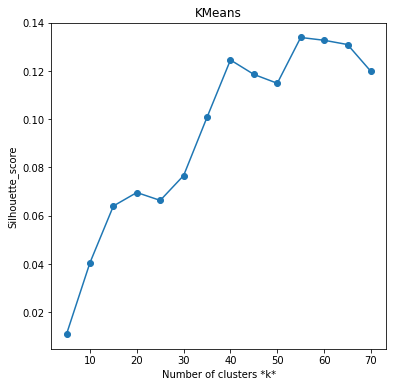

In [48]:
plt.figure(figsize=(6, 6))
plt.title('KMeans')
plt.plot(n_clusters, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Silhouette_score')

* Our Silhoutte score indicates that the clusters are not very well defined, as the SS is very less (A silhoutte Score of 1 suggest perfect cluster boundaries, 0 means that cluster is chosen at random and -1 means not proper boundaries at all).
* Best number of cluster based on SS is somewhere between 50 to 60.

### 4.b. DBSCAN Clustering

This is a density based clustering which doesn't require any initialization in terms of cluster numbers, however, we do optimize two hyper parameters - eps and min_samples to acheive the best clustering results.

In [51]:
min_samples = list(range(5,15,3))
epses = list(np.linspace(15, 45, 3))
sse = []

for min_sample in min_samples:
    for eps in epses:
        db_estimator = Pipeline([('scaler', StandardScaler()),
                         ('dbscan', DBSCAN(eps = eps,
                                           min_samples = min_sample,
                                           metric = 'jaccard'
                                          ))
                        ])
        print(eps, min_sample)
        db_estimator.fit(nmf_features)
        labels = db_estimator.named_steps['dbscan'].labels_
        sse.append(silhouette_score(nmf_features, labels))

15.0 5


c:\users\aa-minhaj\sklearn-venv\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
c:\users\aa-minhaj\sklearn-venv\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
c:\users\aa-minhaj\sklearn-venv\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
c:\users\aa-minhaj\sklearn-venv\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
c:\users\aa-minhaj\sklearn-venv\lib\site-packages\sklearn\metrics\pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

* Here, I actually tried varied range of values for eps and min_samples to achieve convergence. 
* Unfortunately, all my efforts came to naught and the model failed to converge over a wide range of values of hyperparameters.
* Here, I also deviated from K-Means algorightm by chosing a distance metric more suitable for NLP tasks i.e. Jaccard.

In [ ]:
plt.figure(figsize=(6, 6))
plt.title('KMeans')
plt.plot(n_clusters, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Silhouette_score')

### 4.c. Agglomerative Clustering

One of the widely used and easily interpretable algorithm. Again since the algorithm provides the option to stop clustering at a predefined mark (Cluster Numbers), I opted to iterate that number over the range from 5 to 70.

In [58]:
n_clusters = list(range(5,71,5))
sse = []

for cluster in n_clusters:
    agc_estimator = Pipeline([('scaler', StandardScaler()),
                              ('agc', AgglomerativeClustering(n_clusters = cluster,
                                                              affinity = 'euclidean',
                                                              linkage = 'ward'))])
    agc_estimator.fit_predict(nmf_features)
    labels = agc_estimator.named_steps['agc'].labels_
    sse.append(silhouette_score(nmf_features, labels))

Text(0, 0.5, 'Silhouette_score')

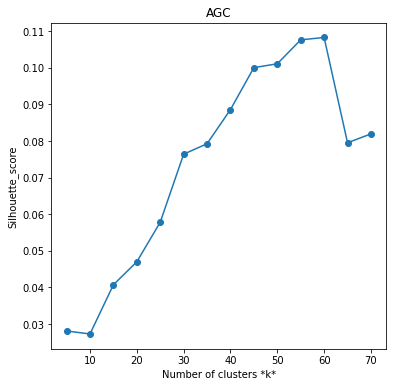

In [59]:
plt.figure(figsize=(6, 6))
plt.title('AGC')
plt.plot(n_clusters, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Silhouette_score')

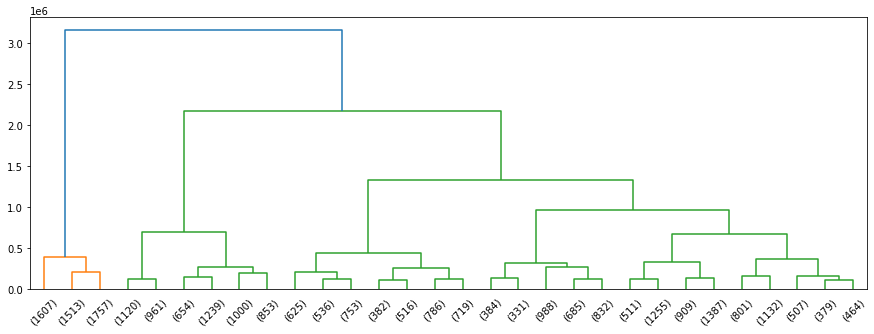

In [61]:
from scipy.cluster import hierarchy

ag = agc_estimator.named_steps['agc']

Z = hierarchy.linkage(ag.children_, method='ward')

fig, ax = plt.subplots(figsize=(15,5))

den = hierarchy.dendrogram(Z, orientation='top', 
                           p=30, truncate_mode='lastp',
                           show_leaf_counts=True, ax=ax)

* Once again the SS suggests that clustering results obtained are not very clear.
* Agglomerative Clustering method does converge eventually here but with worst results when compared to KMeans.
* The Best SS score that I obtained using euclidean distance and ward linkage was around 0.11 with resulting number of clusters between 50 to 55.
* I also tried Cosine distance but the results were even worser.

## Model Evaluation and Selection - Summary

* We tried to train 3 models and chose hyperparameters by using for loop
>1. K Means Clustering
>2. DBSCAN
>3. Agglomerative Clustering
* We set forth our expectations clearly, by setting goals as to identify/ validate the clusters using pre-defined labels available with us in the dataset.
* The model which presented best solution was suprisingly KMeans with ideal number of clusters between 50 - 55
* We saw that DBSCAN failed to coverge and Agglomerative clustering also suggested similar number of clusters as K-Mean but with lower Silhoutte Score.
* We will discuss the implications of our modelling results in next section.

## 5. Conclusion and Future Directions

In conclusion, we can conclude that Kmeans provides the best clustering results with optimal number of clusters somewhere between 50 to 55.

Going further, in future we may improve our modelling performance by,

* At the time of feature extraction we only used unigrams and bigrams, we can also use further higher degree of feature such as trigram (combination of three words)
* The no of components that we used for further modelling was fixed to 70. However, we may try to further minimize the components and check the explained variance to chose the optimal number. We can then use the new components to again perform the clustering to check for any improved performance.
* While training DBSCAN Clustering algorightm I failed to obtain any convergence. Maybe we can try for even larger or smaller values of eps and min_samples to check for convergence.
* Both KMEANS as well as the Agglomerative clustering methods suggest that the optimal number of clusters is somewhere between 55-60. This may be useful for re-classifying our original dataset and resduce the number of features to the optimal cluster numbers. This would be the final outcome of our project.

## Thank You, for visiting my page and going through this notebook.

# CIAO !!